In [1]:
import numpy as np
import random
import math

In [2]:
class Layer:
    """
    The base layer class for all layers

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name):
        """
        The constructor for the layer class

        Parameters:
            name: The name of the layer
        """

        self.name = name
        self.input_shape = None
        self.output_shape = None

    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            x: The input to the layer

        Returns:
            The output of the layer
        """

        raise NotImplementedError

    def backward(self, output_grad, learning_rate):
        # we can use an optimizer instead of learning rate
        """
        The backward pass of the layer

        Parameters:
            grad: The gradient of the loss w.r.t. the output of the layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        raise NotImplementedError

In [30]:
def xavier_initialization(m, n):
    """
    Xavier initialization for the weights of a layer

    Parameters:
        m: The number of rows in the weight matrix
        n: The number of columns in the weight matrix

    Returns:
        The initialized weights
    """

    random.seed(282)
    
    weights = [[0 for _ in range(n)] for _ in range(m)]
    for i in range(m):
        for j in range(n):
            weights[i][j] = random.gauss(0, math.sqrt(2.0 / (m + n)))
    return weights

In [32]:
class DenseLayer(Layer):
    """
    The dense layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
        weights: The weights of the layer
        bias: The bias of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name, input_shape, output_shape):
        """
        The constructor for the dense layer class

        Parameters:
            name: The name of the layer
            input_shape: The shape of the input to the layer
            output_shape: The shape of the output of the layer
        """

        super().__init__(name)
        self.input_shape = input_shape
        self.output_shape = output_shape
     
        # self.weights = np.array(xavier_initialization(output_shape, input_shape))
        # w_ji -> j: output, i: input

        np.random.seed(182)
        
        self.weights = np.random.randn(output_shape, input_shape)
        self.bias = np.random.randn(output_shape, 1)
        # randn returns a sample from the "standard normal" distribution

    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        self.input = input

        # print ("input shape: ", self.input.shape)
        # print ("weights shape: ", self.weights.shape)
        # print ("bias shape: ", self.bias.shape)

        return np.dot(self.weights, self.input) + self.bias
    

    def backward(self, output_grad, learning_rate):
        """
        The backward pass of the layer

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the layer
     
        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """
        # output_grad: dL/dy (L: loss, y: output of the layer)
        # output_grad: The gradient of the loss w.r.t. the output of the layer

        # todo: do the math and keep note for evaluation
    
        weights_grad = np.dot(output_grad, self.input.T)
        # dL/dB = dL/dy * dy/dB = dL/dy * 1
        bias_grad = output_grad

        # input_grad: dL/dx
        input_grad = np.dot(self.weights.T, output_grad)

        # todo minibatch gradient descent

        self.weights -= learning_rate * weights_grad
        self.bias -= learning_rate * bias_grad

        return input_grad

In [5]:
class ActivationLayer(Layer):
    """
    The activation layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name, activation_func, activation_func_prime):
        """
        The constructor for the activation layer class

        Parameters:
            name: The name of the layer
            activation_func: The activation function of the layer
            activation_func_prime: The derivative of the activation function of the layer
        """

        super().__init__(name)

    
        self.activation_func = activation_func
        self.activation_func_prime = activation_func_prime

        

    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        self.input = input

        return self.activation_func(input)

    def backward(self, output_grad, learning_rate):
        """
        The backward pass of the layer

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the layer
            learning_rate: dummy for activation layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        return np.multiply(output_grad, self.activation_func_prime(self.input))
    

In [6]:
class ReLUActivationLayer(ActivationLayer):
    """
    The ReLU activation layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name):
        """
        The constructor for the ReLU activation layer class

        Parameters:
            name: The name of the layer
        """

        super().__init__(name, lambda x: np.maximum(x, 0), lambda x: np.where(x > 0, 1, 0))



In [7]:
def cross_entropy_loss(y, y_pred):
    """
    The cross entropy loss function

    Parameters:
        y: The ground truth
        y_pred: The predictions

    Returns:
        The loss
    """


    epsilon = 1e-15  # small value to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    # limits the values in the y_pred array to be within the range 
    # [epsilon, 1 - epsilon]. This ensures that the predicted probabilities are not exactly zero or one
    
    # print ("y size: ", y.size)
    # print ("y_pred: ", y_pred)

    return -np.sum(np.multiply(y, np.log(y_pred))) / y.size

    # return -np.sum(y * np.log(y_pred)) / y.size

def cross_entropy_loss_prime(y, y_pred):
    """
    The derivative of the cross entropy loss function

    Parameters:
        y: The ground truth
        y_pred: The predictions

    Returns:
        The derivative of the loss w.r.t. the predictions
    """

    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    return -np.divide(y, y_pred) / y.size

In [8]:
def mse_loss(y, y_pred):
    """
    The mean squared error loss function

    Parameters:
        y: The ground truth
        y_pred: The predictions

    Returns:
        The loss
    """

    return np.mean(np.square(y - y_pred))

def mse_loss_prime(y, y_pred):
    """
    The derivative of the mean squared error loss function

    Parameters:
        y: The ground truth
        y_pred: The predictions

    Returns:
        The derivative of the loss w.r.t. the predictions
    """

    return 2 * (y_pred - y) / y.size

Moodle instructed dataset loading

In [9]:
import torchvision.datasets as ds
from torchvision import transforms


train_validation_dataset = ds.EMNIST(root='./data', split='letters',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)


# independent_test_dataset = datasets.dsets.EMNIST(root='./data',
#                        split='letters',
#                              train=False,
#                              transform=transforms.ToTensor())



In [10]:
train_validation_dataset

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
# Split the train-validation dataset as 85%-15% to form your train set and validation set using sklearn.model_selection.train_test_split

from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_validation_dataset, test_size=0.15, random_state=82)




In [12]:
def show_images(dataset, num_images=5):
    """
    Show the first num_images images of the dataset

    Parameters:
        dataset: The dataset to show the images from
        num_images: The number of images to show
    """
    import matplotlib.pyplot as plt

    # Create a figure to display the images
    fig = plt.figure()

    # Loop over the first num_images images in the dataset
    for i in range(num_images):
        # Get the image and its label
        image, label = dataset[i]

        # The image needs to be transposed to be displayed correctly
        image = image.transpose(0,2).transpose(0,1)

        # Display the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

    # Display the figure
    plt.show()

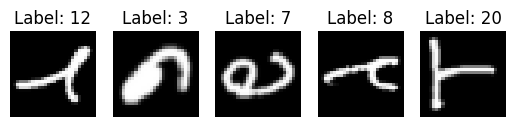

In [13]:
show_images(train_dataset)

In [39]:

# XOR dataset

X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
# print ("X: ", X)
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

# MNIST dataset

# X = np.array([np.array(x[0]).flatten() for x in train_dataset])
# Y = np.array([x[1] for x in train_dataset])

# X = np.reshape(X, (X.shape[0], X.shape[1], 1))
# Y = np.reshape(Y, (Y.shape[0], 1, 1))

# print ("X: ", X)
# print ("X shape:", X.shape)
# print ("Y: ", Y)
# print ("Y shape:", Y.shape)

network = [
    DenseLayer("Dense1", X.shape[1], 3),
    ReLUActivationLayer("ReLU1"),
    DenseLayer("Dense2", 3, 1),
    ReLUActivationLayer("ReLU2")
]

learning_rate = 0.01
epochs = 20

for epoch in range(epochs):
    loss = 0
    for x, y in zip(X, Y):
        output = x
        # print ("output: ", output)
        for layer in network:
            # print ("layer: ", layer.name)
            output = layer.forward(output)

        # loss += mse_loss(y, output)
        # output_grad = mse_loss_prime(y, output)

        loss += cross_entropy_loss(y, output)
        output_grad = cross_entropy_loss_prime(y, output)

        for layer in reversed(network):
            output_grad = layer.backward(output_grad, learning_rate)

    # if epoch % 1000 == 0:
   
    print(f'Epoch: {epoch}\tLoss: {loss:.7f}')

        

Epoch: 0	Loss: 0.8421013
Epoch: 1	Loss: 0.5714817
Epoch: 2	Loss: 0.3888343
Epoch: 3	Loss: 0.2844479
Epoch: 4	Loss: 0.1974869
Epoch: 5	Loss: 0.1227138
Epoch: 6	Loss: 0.0569513
Epoch: 7	Loss: 0.0000000
Epoch: 8	Loss: 0.0000000
Epoch: 9	Loss: 0.0000000
Epoch: 10	Loss: 0.0000000
Epoch: 11	Loss: 0.0000000
Epoch: 12	Loss: 0.0000000
Epoch: 13	Loss: 0.0000000
Epoch: 14	Loss: 0.0000000
Epoch: 15	Loss: 0.0000000
Epoch: 16	Loss: 0.0000000
Epoch: 17	Loss: 0.0000000
Epoch: 18	Loss: 0.0000000
Epoch: 19	Loss: 0.0000000
